Define expert roles
- Technology
- Services
- Materials
- Industries
- Regions

In [12]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


In [13]:
import os
import getpass

from langchain_openai import ChatOpenAI

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")


llm = ChatOpenAI(model="gpt-4o-mini")

In [14]:
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field


In [15]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)


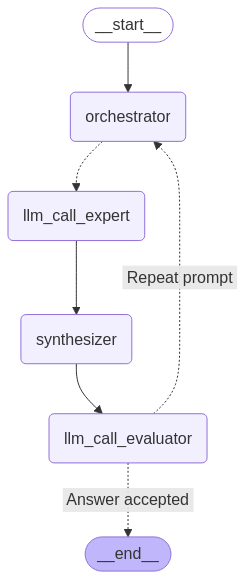

KeyError: 'topic'

In [18]:

from langgraph.constants import Send

# Graph state
class State(TypedDict):
    # topic: str  # Report topic
    # sections: list[Section]  # List of report sections
    # completed_sections: Annotated[
    #     list, operator.add
    # ]  # All workers write to this key in parallel
    # final_report: str  # Final report
    final_answer: str


# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call_expert(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                # content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
                content=f"Write a summary by querying for information, you are an llm_call_expert in {state['llm_call_expert_role'].description}."
            ),
            HumanMessage(
                # content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
                content=f"The original prompt was: {state['original_prompt']}. Focus only on your role: {state['llm_call_expert_role'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"research results": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

class Feedback(BaseModel):
    is_good_answer: bool = Field(
        description="Decide if the output of the LLM provides a question to the user.",
    )


evaluator = llm.with_structured_output(Feedback)

def llm_call_evaluator(state: State):
    """The evaluator LLM evaluates the outputs"""

    evaluation = evaluator.invoke(f"Rate the output of the LLM call {state['llm_call']} from the original prompt {state['original_prompt']}")
    return {"evaluation": evaluation.is_good_answer}


def route_answer(state: State):
    if state["evaluation"]:
        return "Answer accepted"
    else:
        return "Repeat prompt"


# Conditional edge function to create llm_call_expert workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call_expert", {"section": s}) for s in state["sections"]]


# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call_expert", llm_call_expert)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)
orchestrator_worker_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call_expert"]
)
orchestrator_worker_builder.add_edge("llm_call_expert", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", "llm_call_evaluator")
orchestrator_worker_builder.add_conditional_edges(
    "llm_call_evaluator", route_answer, {
        "Answer accepted": END,
        "Repeat prompt": "orchestrator"
    }
)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})

from IPython.display import Markdown
Markdown(state["final_report"])
